# 1. Imporation des données

In [40]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

# 2. Recuperation des données

In [41]:
train_path= './lung_disease/train/'
valid_path = './lung_disease/val/'
test_path = './lung_disease/test/'

# 3. Préparation des données

In [42]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 250
img_width = 250

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [44]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      ) 

Found 6326 images belonging to 4 classes.
Found 771 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


# 4.Affichage des données

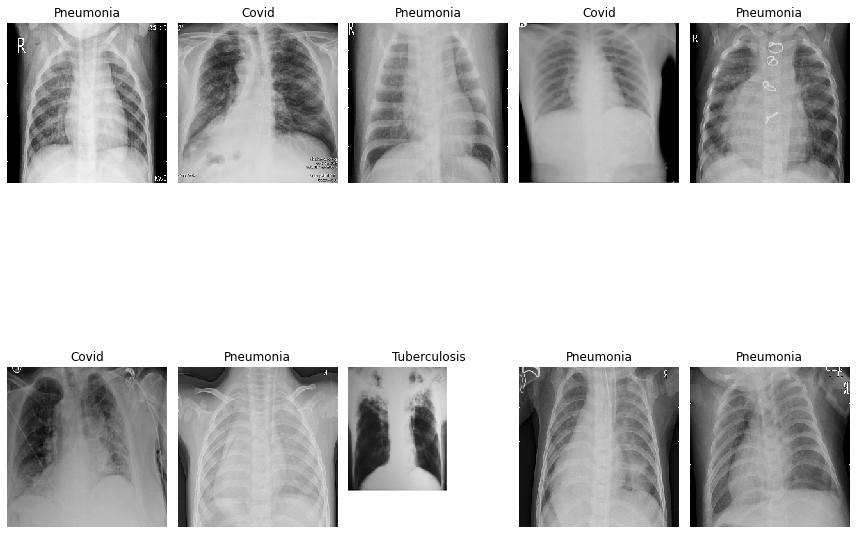

In [45]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'Covid', 1:'Normal', 2:'Pneumonia',3:'Tuberculosis'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 5. Creation du modéle 

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [47]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dropout(.2))
model.add(Dense(activation = 'relu', units = 64))

model.add(Dense(4,activation = 'softmax'))  # the output layer

In [48]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 248, 248, 32)      320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 27, 27, 64)       

In [50]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [51]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 3.4380434782608695, 1: 1.1793437733035048, 2: 0.4081290322580645, 3: 2.433076923076923}


In [52]:
history = model.fit(train,epochs=10, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/10
396/396 [==============================] - 378s 945ms/step - loss: 0.9395 - accuracy: 0.6345 - val_loss: 0.8219 - val_accuracy: 0.6053
Epoch 2/10
396/396 [==============================] - 387s 974ms/step - loss: 0.5066 - accuracy: 0.8252 - val_loss: 0.4095 - val_accuracy: 0.7895
Epoch 3/10
396/396 [==============================] - 415s 1s/step - loss: 0.4015 - accuracy: 0.8682 - val_loss: 0.6747 - val_accuracy: 0.6053
Epoch 4/10
396/396 [==============================] - 391s 986ms/step - loss: 0.3373 - accuracy: 0.8852 - val_loss: 0.4772 - val_accuracy: 0.7895

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/10
396/396 [==============================] - 390s 984ms/step - loss: 0.2170 - accuracy: 0.9271 - val_loss: 0.3031 - val_accuracy: 0.8947
Epoch 6/10
396/396 [==============================] - 388s 978ms/step - loss: 0.1855 - accuracy: 0.9379 - val_loss: 0.4424 - val_accuracy: 0.8684
Epoch 7/10
396/396 [==========================

# 6. évaluation du modéle

In [53]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

49/49 [==============================] - 39s 738ms/step - loss: 0.7774 - accuracy: 0.8067
The testing accuracy is : 80.67445158958435 %


In [54]:
pred = model.predict_classes(test,verbose=1)

C:\Users\DELL INSPIRON\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


49/49 [==============================] - 43s 810ms/step


<AxesSubplot:>

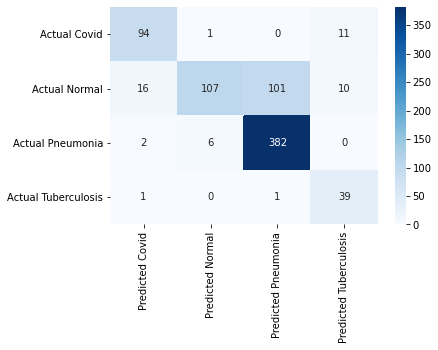

In [55]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, pred, labels=[0,1,2,3]),index=["Actual Covid", "Actual Normal","Actual Pneumonia","Actual Tuberculosis"],
columns=["Predicted Covid", "Predicted Normal","Predicted Pneumonia","Predicted Tuberculosis" ])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap='Blues')

In [56]:
print(classification_report(y_true=test.classes,y_pred=pred,target_names =['Covid','NORMAL','Pneumonia','TUBERCULOSIS']))

              precision    recall  f1-score   support

       Covid       0.83      0.89      0.86       106
      NORMAL       0.94      0.46      0.61       234
   Pneumonia       0.79      0.98      0.87       390
TUBERCULOSIS       0.65      0.95      0.77        41

    accuracy                           0.81       771
   macro avg       0.80      0.82      0.78       771
weighted avg       0.83      0.81      0.79       771



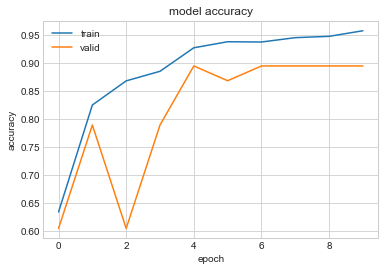

In [57]:
plt.style.use('seaborn-whitegrid')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

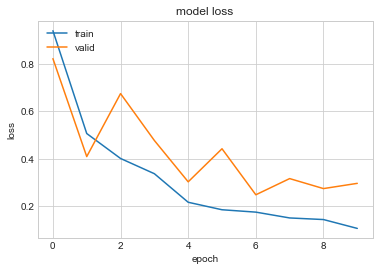

In [58]:
plt.style.use('seaborn-whitegrid')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Prediction avec le modéle

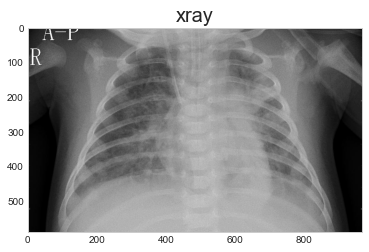

In [59]:
import matplotlib.pyplot as plt
img = plt.imread('image2.jpeg')
plt.grid(b=None)
plt.imshow(img,cmap='gray')
plt.title('xray',fontsize=20)
plt.show()

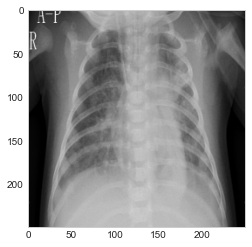

In [66]:
from skimage.transform import resize
rsz_img = resize(img,(250,250,1))
plt.grid(b=None)
plt.imshow(rsz_img,cmap='gray')

In [67]:
im_pred = model.predict(np.array([rsz_img]))
pct = im_pred * 100
pct

array([[5.8759415e-01, 1.7658472e-02, 9.9393738e+01, 1.0042355e-03]],
      dtype=float32)

cet individu a 0.5875941514968872 % de chance d'avoir la covid-19  
cet individu a 0.017658472061157227 % de chance d'etre Normal  
cet individu a 99.39373779296875 % de chance d'avoir la pneumonie  
cet individu a 0.0010042354697361588 % de chance d'avoir la tuberculose 


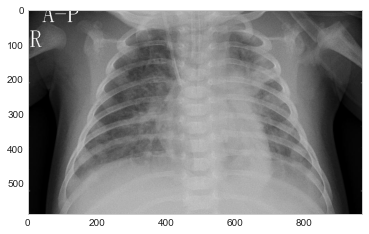

In [73]:
txt= 'cet individu a {} % de chance d\'avoir la covid-19  '
print(txt.format(pct[0,0]))
txt= 'cet individu a {} % de chance d\'etre Normal  '
print(txt.format(pct[0,1]))
txt= 'cet individu a {} % de chance d\'avoir la pneumonie  '
print(txt.format(pct[0,2]))
txt= 'cet individu a {} % de chance d\'avoir la tuberculose '
print(txt.format(pct[0,3]))

plt.grid(b=None)
plt.imshow(img,cmap='gray')
plt.show()

# Sauvegarde du modéle

In [69]:
model.save('Lung_disease_classifier.h5')